<H1>Проектная работа "Принятие решений в бизнесе" </H1>

**Введение**:
Небходимо провести аналитический проект для крупного интернет-магазина. При помощи отдела маркетинга был подготовен список гипотез для увеличения выручки.

**Цель**: Провести А/В тестирование для интернет-магазина, опираясь на цель максимизации выручки.

**Исходные данные**:
- данные о каждом заказе интернет-магазина (дата, выручка, группа для теста)
- данные о кол-ве пользователях по датам

**План**:
1. Первичная обработка данных
- обзор данных
- проверка на пропуски
- проверка на дубликаты
- проверка на корректность типов данных
2. Приоритизация гипотез методами ICE и RICE
- подсчет оценок ICE и RICE 
- выявление приоритетных гипотез
3. Анализ А/В теста:
- Кумулятивная выручка по группам
- Кумулятивный средний чек по группам
- Кумулятивное среднее количество заказов по группам
- Проверка на проблемы аномалий
- Удаление аномалий
- Сравнение выводов для "сырых" и обработанных данных
- Принятие решения об окончании или продлении проведения теста, резюмирование результатов, выявление победившей группы.


### Первичная обработка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
display(orders.head(5))
display(visitors.head(5))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Пропусков в данных нет.

In [5]:
orders['date'] = pd.to_datetime(orders['date']) #меняем тип данных на дату
visitors['date'] = pd.to_datetime(visitors['date'])

In [6]:
print(orders.duplicated().sum()) #явных дубликатов в таблицах нет
print(visitors.duplicated().sum())

0
0


In [7]:
A = orders.query('group == "A"')
B = orders.query('group == "B"')
print(len(A), len(B))

557 640


In [8]:
visitors_A = list(A['visitorId'].unique())
visitors_B = list(B['visitorId'].unique())

common_elements = list(set(visitors_A) & set(visitors_B))
print('Пользователей, попавших в обе группы:', len(common_elements))
print('Доля таких пользователей:', np.round(len(common_elements) / orders['visitorId'].nunique() * 100, 2))

Пользователей, попавших в обе группы: 58
Доля таких пользователей: 5.63


Пользователей, попавших в обе группы: 5.6%. \
Доля небольшая, однако ее достаточно для того, чтобы исказить результаты теста. Поэтому уберем этих пользователей из группы, так как мы не знаем, к какой группе их лучше отнести.

In [9]:
orders = orders[~orders['visitorId'].isin(common_elements)]
print('Осталось наблюдений:', orders.shape[0])

Осталось наблюдений: 1016


### Приоритизация гипотез методами ICE и RICE

In [10]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Гипотез много, а ресурсы и время всегда ограничены. Поэтому нужно проверять, какие гипотезы следует тестировать в первую оченедь. \
Метод ICE - один из самых популярных способов приоритизации задач. \
Он рассчитывается на основе оценки влияния на пользователей (impact), оценки нашей уверенности в том, что измение повлияет именно таким образом (comfidence) и затрат на данную гипотезу (efforts). \

У метода ICE есть аналог - метод RICE. К формуле ICE добавляется оценка количества пользоватлеей, которых затронет изменение (reach)

In [11]:
hypothesis['ice'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['rice'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [12]:
#ICE:
pd.options.display.max_colwidth = 400

hypothesis[['Hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,Hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Судя по ICE SCORE в первую очередь следует провести тест гипотез c индексами 8, 0, 7 и 6.

In [13]:
#RICE:

hypothesis[['Hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,Hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


После приоритизации гимпозу методом RICE мы получили важность тех же гипотез с индексами 7, 0 и 6. Однако, также важной оказалась гипотеза-2, а вот восьмая ушла на 5 место. 

Вывод: первый приоритет стоит отдать гипотезе с индексом 7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". \
И дальше гипотезе с индексом 0: "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

In [14]:
print(hypothesis.loc[7, 'Hypothesis'])
print(hypothesis.loc[0, 'Hypothesis'])

Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


### Анализ А/В теста

#### Кумулятивная выручка по группам

In [15]:
datesGroups = orders[['date','group']].drop_duplicates()

#создаем аггрегированные таблицы для заказов и посетителям сгрупированные по датам и группам
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
    visitors['group'] == x['group'])].agg({
    'date' : 'max', 
    'group' : 'max', 
    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#созединяем таблицы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

#переиновывем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


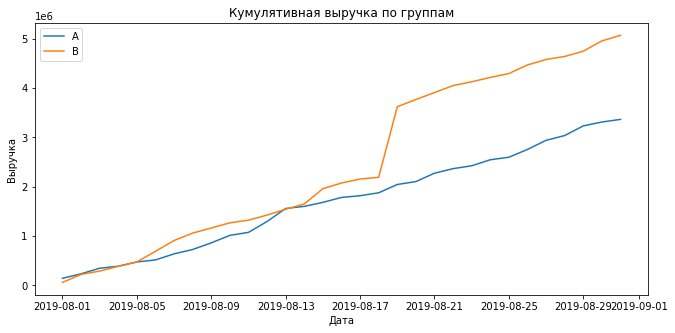

In [16]:
#создаем отдельные таблицы для групп
cumulativeRevenueA = cumulativeData.query('group == "A"')[['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData.query('group == "B"')[['date','revenue', 'orders']]


plt.figure(figsize=(11, 5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend() ;

В середине теста группа В резко выросла в кумулятивной выручке. Что-то произошло 18-20 августа 2019 года в группе В. Возможно, аномальная покупка, это нужно будет проверить, чтобы выбросы не повлияли на результаты теста. 

#### Кумулятивные средние чеки по группам

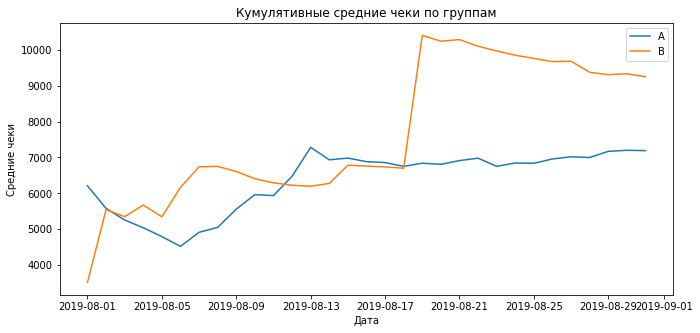

In [17]:
plt.figure(figsize=(11, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивные средние чеки по группам')
plt.ylabel('Средние чеки')
plt.xlabel('Дата')
plt.legend();

Средние чеки в обеих группах на протяжении всего теста колеблются, особенно группа В. \
Перед окончатлельным решением и проверкой гипотезы проверить данные на выбросы, и в случае их наличия, исключить их из теста. Так как наличие экстремально больших заказов - не результат изменения продукта для группы В, а лишь случайность.

####  Относительное изменение кумулятивного среднего чека группы B к группе A

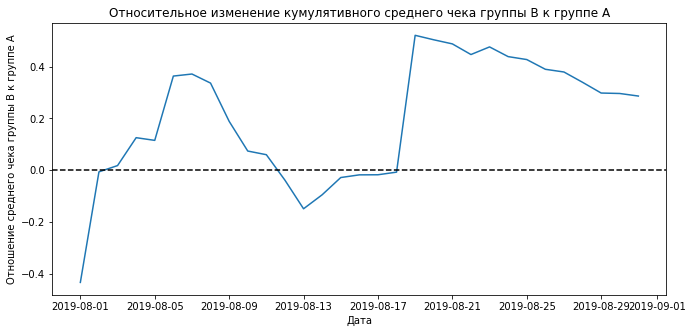

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(11, 5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.ylabel('Отношение среднего чека группы В к группе А')
plt.xlabel('Дата')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

В начале теста средний чек пользователей из группы В стремительно рос и превышал средний первой группы. Однако, позже на протяжении всего теста успешность группы В варьировалась от -10% до 50%. Скорее всего, эти колебания связаны именно с наличием заказов-выбросов в эти даты.

#### Кумулятивное среднее количество заказов на посетителя по группам

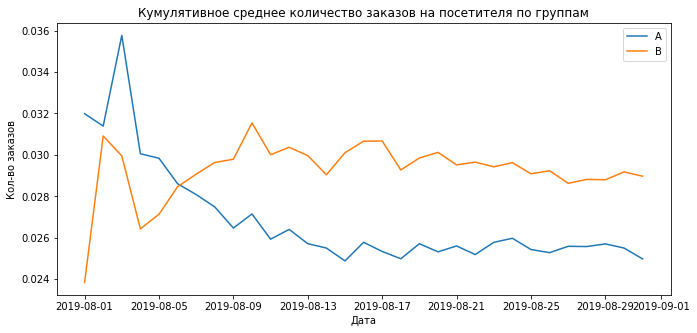

In [19]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(11, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.ylabel('Кол-во заказов')
plt.xlabel('Дата')
plt.legend();

Спустя 5 дней проведения теста группа В значительно превысила группу А по кол-ву заказов на одного покупателя. 

#### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

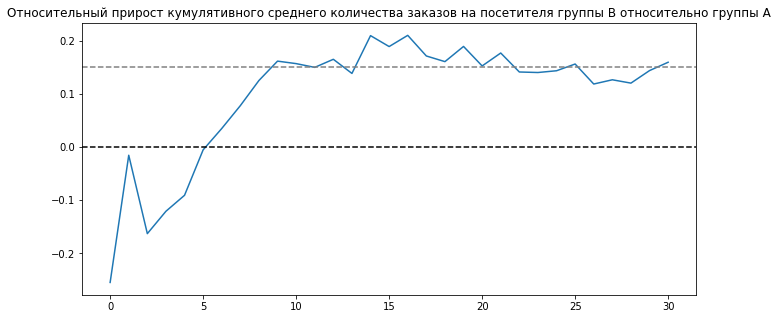

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeConversion = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                   left_on='date', right_on='date', how='left', suffixes=['A','B'])
plt.figure(figsize=(11, 5))
# cтроим отношение среднего количества заказов
plt.plot(mergedCumulativeConversion['conversionB'] / mergedCumulativeConversion['conversionA'] - 1)
plt.title("Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--');

Почти с самого начала теста группа B лидирует по метрике. Спустя неделю зафиксировалась на уровке около 15%.

#### Поиск аномалий: количество заказов на пользователей

In [21]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})

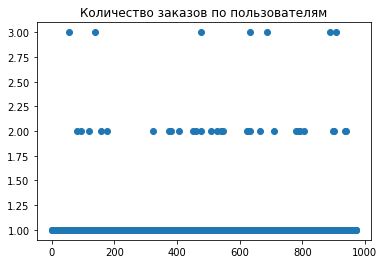

In [22]:
x_values = pd.Series(range(0, len(ordersByUsers['transactionId'])))
                           
plt.scatter(x_values, ordersByUsers['transactionId'])
plt.title('Количество заказов по пользователям');

В основном пользователи совершили за период проведения теста до 2-3 заказов. \
Случаев, когда заказов на пользователя больше - немного. Далее посмотрим, во сколько заказов укладывается 95% пользователей.

In [23]:
np.percentile(ordersByUsers['transactionId'], [95, 98, 99])

array([1., 2., 2.])

Меньше 1% пользователей оформило заказ больше 2 раз, и менее 5% - больше 1 раза. \
Лучше взять 98-й перцентиль - 2 заказа. \
Тогда, мы отбросим лишь менее 1% пользователей из данных, которые совершили более 2 заказов

#### Поиск аномалий: стоимость заказов

In [24]:
sumsByUsers = orders.groupby('visitorId', as_index=False).agg({'revenue': 'sum'})

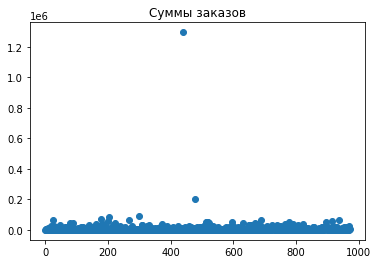

In [25]:
x_values = pd.Series(range(0, len(sumsByUsers['revenue'])))
plt.scatter(x_values, sumsByUsers['revenue'])
plt.title('Суммы заказов');

Есть явный аномальный заказ суммой на 120 тыс. В остальном, все заказы в основном до 70 тыс. Проверим на процентных соотношениях:

In [26]:
np.percentile(sumsByUsers['revenue'], [95, 99])

array([28910., 59082.])

Как и было видно по графику, практически все заказы были совершены до 100 тыс. Однако, с помощью перцентилей мы может сделать более точные выводы:
- Менее 1% пользователей совершали покупки более чем на 59 082 рублей;
- Менее 5% пользователей тратили более 28 910 рублей.

Признаем аномальными пользователей, совершивших заказы в сумме более чем на 59 082 рублей.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Применим непараматрический тест Манна-Уитни:

Н0 - среднее кол-во заказов на посетителя группы А и В не отличаются, или отличаются не значимо \
Н1 - присутствует статистически значимая разница между средним кол-вом заказов на пользователя.

In [27]:
ordersByUsersA = orders.query('group == "A"').groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsersB = orders.query('group == "B"').groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})

#считаем ежедневное кол-во посетителей:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#создаем группы со всеми пользователями по группам:
sampleA = pd.concat([ordersByUsersA['transactionId'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])), name='transactionId')],axis=0)

sampleB = pd.concat([ordersByUsersB['transactionId'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])), name='transactionId')],axis=0)

In [28]:
print('P-value =', "{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Отношение В к А = ', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value = 0.01102
Отношение В к А =  0.160


P-value значительно меньше 5%, значит, судя по "сырым" данным, нулевая гипотеза о схожести конверсий двух групп отвергается. \
В среднем в количестве заказов на посетителя группы В на 16.0% выше группы А.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Н0 - средний чек групп А и В не отличаются, или отличаются не значимо \
Н1 - присутствует статистически значимая разница между средним чеком.

In [29]:
print('P-value =', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Отношение В к А = ', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value = 0.829
Отношение В к А =  0.287


Нулевая гипотеза о равенстве средних чеков двух групп не отвергается, так как p-value сильно больше 5%. \
Наблюдаемая разница - средний чек группы В на 28.7% превосходит средний чек группы А - не является значимой, судя по "сырым" данным.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Мы приняли за аномалии:
- заказы в сумме более чем на 59 082 рублей
- пользователи, совершившие более 2 заказов

In [30]:
#аномальные значения:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionId'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['transactionId'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 59082]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitorId, dtype: int64


Всего аномальных пользователей - пятеро. Исключим их из данных и снова проверим гипотезы.

In [31]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])
            ),
            name='transactionId',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])
            ),
            name='transactionId',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00641
0.191


После очищения данных от выбросов, p-value практически не изменился. Он также значительно меньше 5% - мы отвергаем нулевую гипотезу о равенстве среднего количества заказов на посетителя. \
Среднее кол-во заказов пользователей из группы В на 19.1% больше пользователей из группы А (тот же результат по сырым данным - 16.0%).

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [32]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.827
-0.017


Мы не можем отвергнуть нулевую гипотезу о равенстве средних чеков двух групп. \
Средний чек группы В оказался меньше ср. чека группы А на 1.7%, и эта разница не является статистически значимой.


### Решение по результатам теста

После начала теста и разделения пользователей по группам мы получили неоднозначные результаты:
- Среднее кол-во заказов пользователей из группы В больше на 19.1%
- А вот значимой разницы в средних чеках нет (по окончании теста средний чек группы В оказался меньше ср.чека группы А, и всего на 1.7%)

По всей видимости нововведение/улучшение продукта для группы В сильно повлияло на количество заказов, они выросли на 19.1%, что является очень хорошим результатом. Средний чек не изменился, но благодаря росту кол-ва заказов группы В - общий доход с таких заказов - да. 

Поэтому, тест успешный, и победившей группой можно признать группу В. Количество заказов группы В значительно больше, чем у группы А, и применение нововведения принесет бизнесу больший доход. \
Тест можно завершать.